In [1]:
import kagglehub

path = kagglehub.dataset_download("gazu468/cifar10-classification-image")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifar10-classification-image


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time 
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
import math
from PIL import Image
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

**Start of Step 1**

In [3]:
# Creating custom datasets and converting to tensor.
try:
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset=datasets.ImageFolder(root=f"{path}/cifar10/train",transform=transform)
    test_dataset=datasets.ImageFolder(root=f"{path}/cifar10/test",transform=transform)
    print('Finally able to make it to custom dataset.')

except Exception as e:
    print(f'dataset name is still probably off.. {e}')

Finally able to make it to custom dataset.


In [4]:
# Checking the results
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [38]:
# Custom data loader...
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False) # Don't need to shuffle for testing set, as we discussed in class...
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Done')

Done


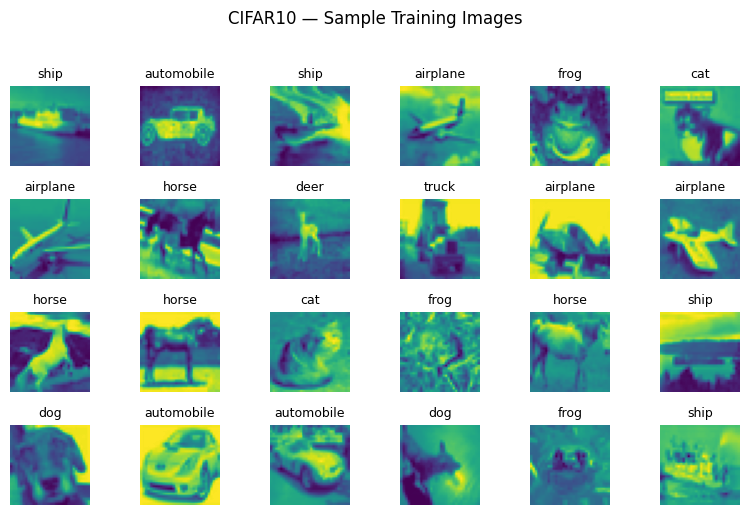

Batch tensor shape: torch.Size([128, 3, 32, 32]) | dtype: torch.float32


In [39]:
# Just looking at the data. Returning a sample of 24 images with their corresponding labels. Categorical turned numberic once it hits the dataloader.
images, labels = next(iter(train_loader))
class_names = getattr(train_loader.dataset, "classes", [str(i) for i in range(10)])

k = 24
rows, cols = 4, 6
fig, axs = plt.subplots(rows, cols, figsize=(8,5))
axs = axs.ravel()
for i in range(k):
    axs[i].imshow(images[i, 0].numpy())
    axs[i].set_title(class_names[int(labels[i])], fontsize=9)
    axs[i].axis("off")
for j in range(k, rows*cols):
    axs[j].axis("off")
plt.suptitle("CIFAR10 — Sample Training Images", y=1.02)
plt.tight_layout()
plt.show()

print("Batch tensor shape:", images.shape, "| dtype:", images.dtype)

**Start of step 2**

In [56]:
class CNN(nn.Module):
    def __init__(self, classes=10):
        super().__init__()

        # Throughout this class we will see bias=False in the nn.Conv2d layers where BatchNorm2d follows. This is because BatchNorm2d introduces its own learnable params...
        self.stem = nn.Sequential( # 2 3x3 convolution layers...
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, bias = False), # First conv layer.
            nn.BatchNorm2d(32), # Normalization
            nn.ReLU(), # Nonlinear activation function

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv_block_1 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, padding=0, stride=1, bias = False), # Point-wise convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1, groups=128, bias = False), # Depth-wise convolution. Has to be same as in_channels and postive integer for out_channels.
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 convolution
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, bias = False), # Stacked 3x3 convolution.
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Downample with max pooling
        self.pooling1 = nn.MaxPool2d(2)

        self.conv_block_2 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=0, stride=1, bias = False), #point-wise convolution on conv block 2
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1, groups=256, bias = False), # depth-wise conv
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), #3x3 conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv stacked
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.pooling2 = nn.MaxPool2d(2)

        self.conv_block_3 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0, stride=1, bias = False), # point-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1, groups=512, bias = False), #depth-wise conv
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # 3x3 conv layer
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, stride=1, bias = False), # stacked 3x3
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        self.pooling3 = nn.MaxPool2d(2)

        # Flattening and linear (MLP head)
        self.fc = nn.Sequential(
            nn.Flatten(), # Flattening the dataset
            nn.Linear(1024 * 4 * 4, 2048), # 4x4 known from downsampling. Bias will remain its default of True here as no batch normalization follows...
            nn.ReLU(),
            nn.Dropout(0.5), # Regularization technique

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, classes)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.conv_block_1(x)
        x = self.pooling1(x) # Max pooling step after conv block 1.
        x = self.conv_block_2(x)
        x = self.pooling2(x)
        x = self.conv_block_3(x)
        x = self.pooling3(x)
        x = self.fc(x)
        return x

In [65]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

**Start of step 3**

In [66]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f'Train epoch {epoch +1}: Loss={loss.item():.4f}')


In [67]:
def test():
    model.eval()
    y_true, y_pred = [], []
    correct, total = 0,0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.numel()

            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
    acc = 100. * correct / len(test_loader.dataset)
    print(f'Test Accuracy: {acc:.2f}%')

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Using actual class names
    class_names = getattr(test_loader.dataset, "classes", None)

    labels = np.arange(len(class_names))

    cm_raw  = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')  # sums to 1

    totals  = cm_raw.sum(axis=1)
    correct_per_class = np.diag(cm_raw)
    per_cls_acc = np.divide(correct_per_class, totals, out=np.zeros_like(correct_per_class, dtype=float), where=totals>0) * 100.0

    # Accuracy table per class
    print("Accuracy table classification")
    print(f"{'Class':<12} {'Correct/Total':>16} {'Accuracy %':>12}")
    for i, name in enumerate(class_names):
        ct = f"{int(correct_per_class[i])}/{int(totals[i])}"
        print(f"{name:<12} {ct:>16} {per_cls_acc[i]:>12.2f}")

    # Confusion matrix
    np.set_printoptions(linewidth=160, suppress=True)
    print("Confusion Matrix (raw counts):\n", cm_raw)
    print("Confusion Matrix (row-normalized):\n", cm_norm)

    # Brief interpretation: top 5 confusions
    off = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_norm[i, j] > 0:
                off.append((cm_norm[i, j], i, j))
    off.sort(reverse=True)
    print("Notable confusions (top 5):")
    for v, i, j in off[:5]:
        print(f"  {class_names[i]} was misclassified as: {class_names[j]}: {v*100:.2f}%")

    ConfusionMatrixDisplay(cm_raw, display_labels=class_names).plot(values_format='d'); plt.title("Raw Count"); plt.show()
    ConfusionMatrixDisplay(cm_norm, display_labels=class_names).plot(values_format='.2f'); plt.title("Normalized"); plt.show()

Train epoch 1: Loss=1.8578
Train epoch 2: Loss=2.1912
Train epoch 3: Loss=1.6265
Train epoch 4: Loss=1.2510
Train epoch 5: Loss=1.1511
Test Accuracy: 50.24%
Accuracy table classification
Class           Correct/Total   Accuracy %
airplane             761/1000        76.10
automobile            84/1000         8.40
bird                 431/1000        43.10
cat                  192/1000        19.20
deer                 575/1000        57.50
dog                  553/1000        55.30
frog                 743/1000        74.30
horse                582/1000        58.20
ship                 558/1000        55.80
truck                545/1000        54.50
Confusion Matrix (raw counts):
 [[761   0 121   5  15   1   2   5  86   4]
 [127  84  12   4   2   2   1   3 210 555]
 [118   0 431  59 211  37 130   7   6   1]
 [ 60   0 389 192  36 169 131  14   7   2]
 [ 48   0 177  15 575  14 131  39   1   0]
 [ 22   0 169 159  51 553  27  18   1   0]
 [ 17   0 159  14  58   7 743   2   0   0]
 [ 18  

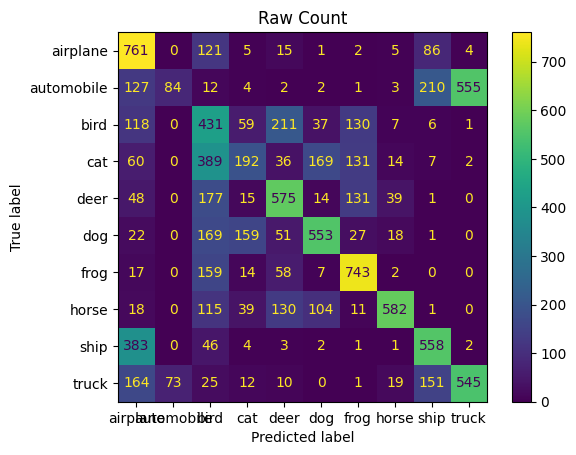

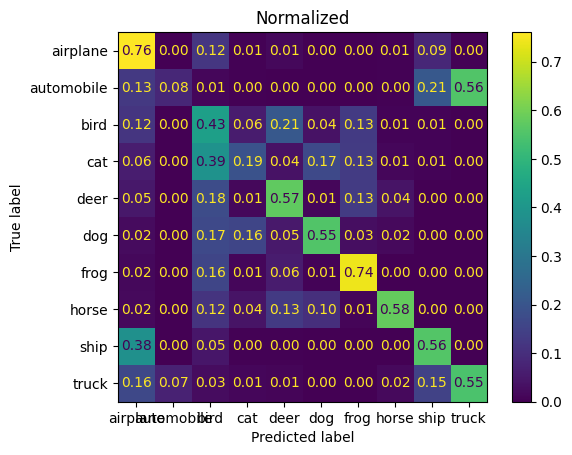

In [68]:
for epoch in range(5):
    train(epoch)
test()